In [11]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [12]:
BreastCancer = pd.read_csv('../data/breast-cancer-wisconsin.csv')
#drop class and id
BreastCancer = BreastCancer.drop(columns=['class', 'id'])
#pasar a numerico la columna bare_nucleoli
BreastCancer['bare_nucleoli'] = pd.to_numeric(BreastCancer['bare_nucleoli'], errors='coerce')
#dropear los nulos
BreastCancer = BreastCancer.dropna()


Kmeans Silhouette Score: 0.5932888484897914 Number of Clusters: 2
Agglomerative Silhouette Score: 0.588720718219059 Number of Clusters: 2


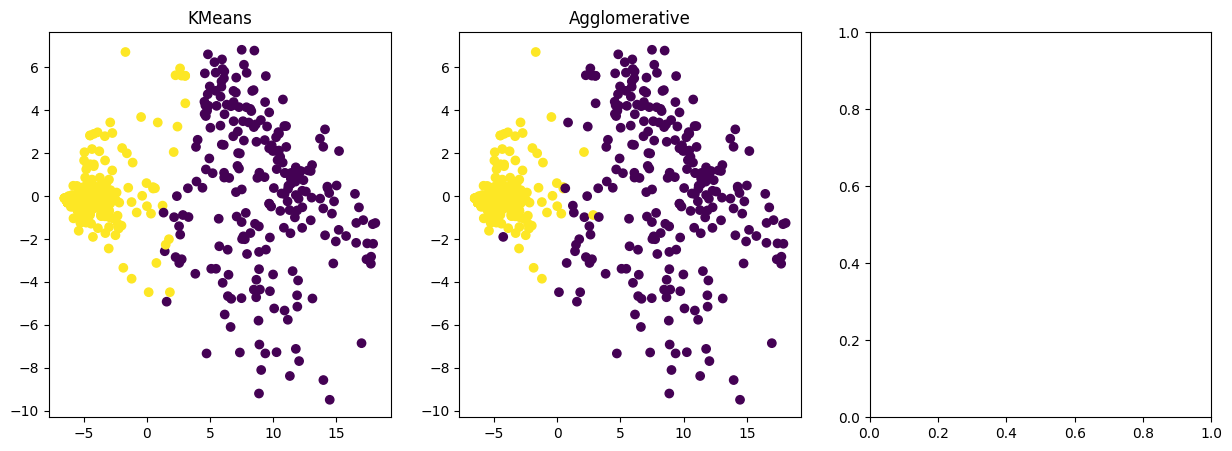

In [21]:
scaler = StandardScaler()
BreastCancer_scaled = scaler.fit_transform(BreastCancer)
BreastCancer_scaled = pd.DataFrame(BreastCancer_scaled, columns=BreastCancer.columns)
nClusters = 2
models = []
kmeans = KMeans(n_clusters=nClusters)
kmeans_labels = kmeans.fit_predict(BreastCancer_scaled)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(BreastCancer, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

agg = AgglomerativeClustering(n_clusters=nClusters)
agg_labels = agg.fit_predict(BreastCancer_scaled)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(BreastCancer, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

# visualize the clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(BreastCancer)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()

## Lime

In [14]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(BreastCancer, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(BreastCancer)))
explainer = LimeTabularExplainer(BreastCancer.values, mode='classification', feature_names=BreastCancer.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(BreastCancer.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(BreastCancer, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(BreastCancer)))
explainer = LimeTabularExplainer(BreastCancer.values, mode='classification', feature_names=BreastCancer.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(BreastCancer.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.9985358711566618


c:\Users\Danie\OneDrive\Documentos\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 1.0


c:\Users\Danie\OneDrive\Documentos\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

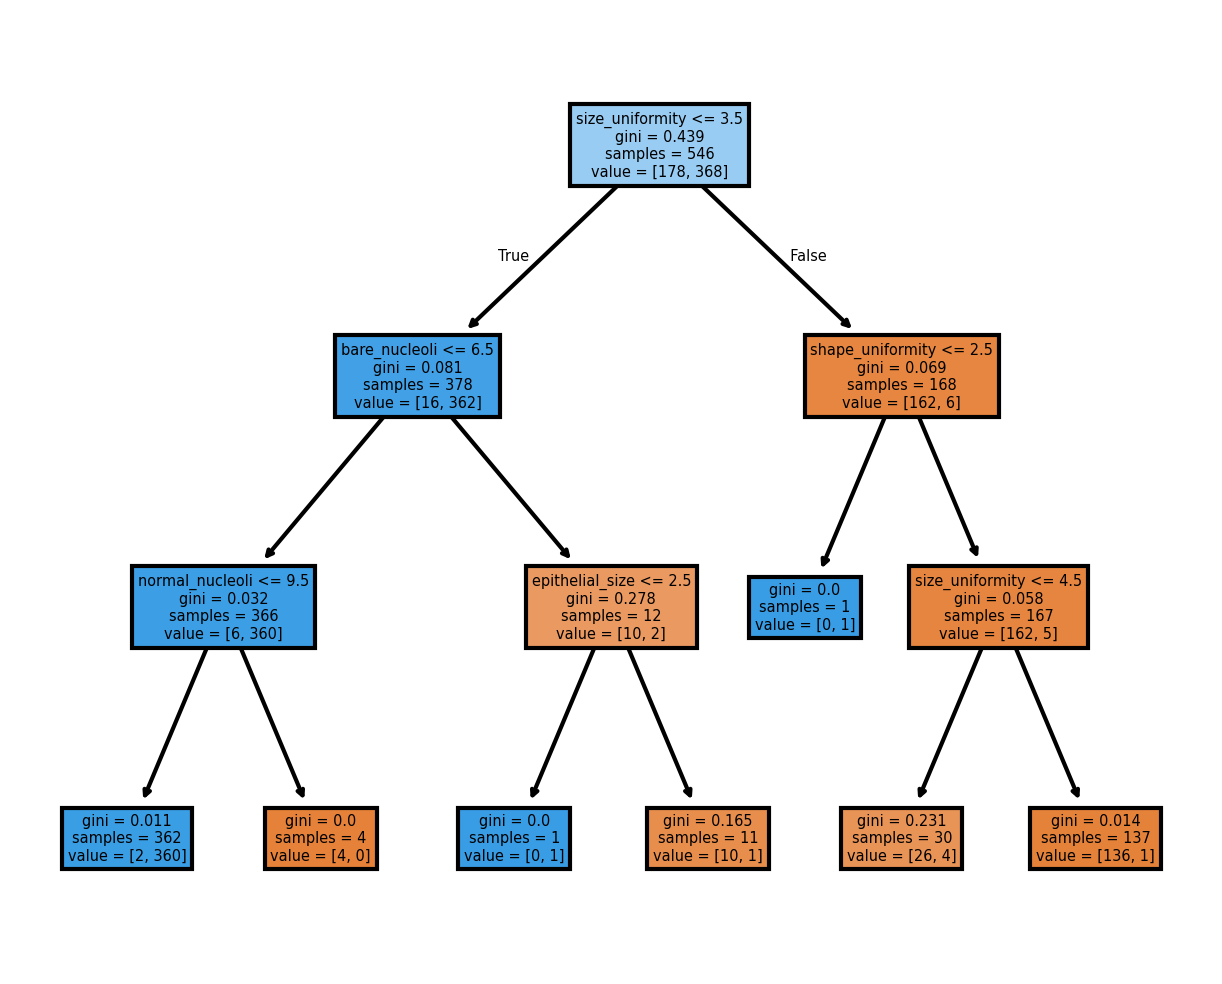

Decision Tree Accuracy: 0.9416058394160584


In [22]:
# interpretamos con decision tree
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, kmeans_labels, test_size=0.2, random_state=42)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=BreastCancer.columns)
plt.show()
y_pred = dt.predict(X_test)
print('Decision Tree Accuracy:', accuracy_score(y_test, y_pred))


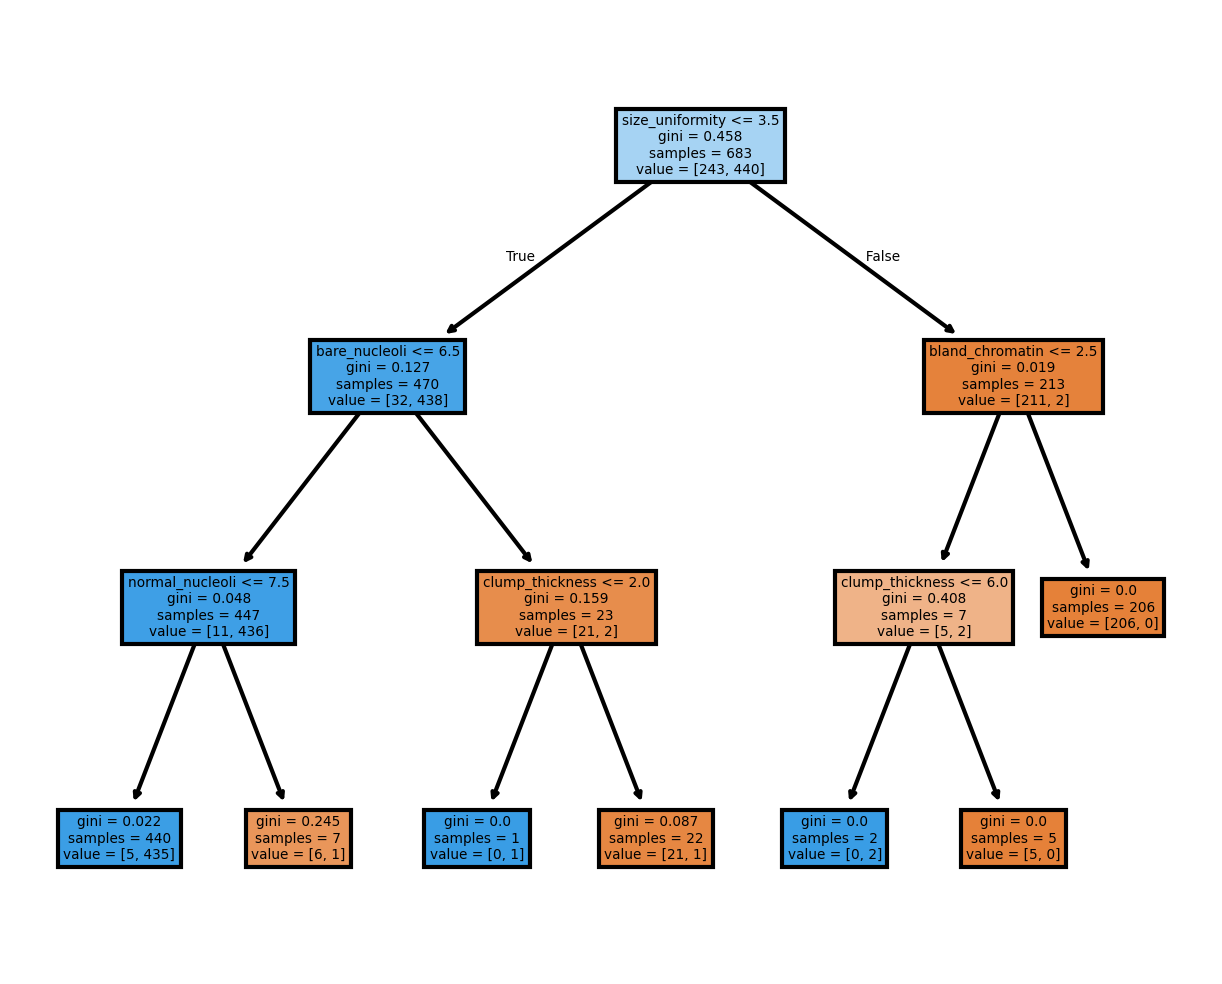

Decision Tree Accuracy: 0.9781021897810219


In [23]:
# interpretamos con decision tree
X_train, X_test, y_train, y_test = train_test_split(BreastCancer, agg_labels, test_size=0.2, random_state=42)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(BreastCancer, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=BreastCancer.columns)
plt.show()
y_pred = dt.predict(X_test)
print('Decision Tree Accuracy:', accuracy_score(y_test, y_pred))

# RIPPER

In [34]:
pos = 1
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([BreastCancer, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(BreastCancer)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([BreastCancer, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(BreastCancer)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[bland_chromatin=<2.0]]
RIPPER Accuracy KMeans: 0.7701317715959004
[[bland_chromatin=<2.0^clump_thickness=4.0-5.0^size_uniformity=2.0-4.0] V [bland_chromatin=<2.0]]
RIPPER Accuracy Agglomerative: 0.7862371888726208


## DSClustering

Optimization started
Processing epoch	373	0.0005	
Training time: 86.78s, epochs: 400

Least training loss reached: 0.000
Accuracy: 98.3%
CD-SGD Silhouette Score: 0.5937292045823019 Number of Clusters: 2


C:\Users\Danie\AppData\Local\Temp\ipykernel_9464\2163327956.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


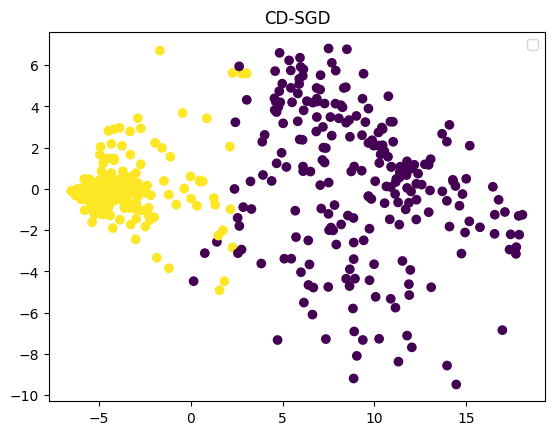

In [18]:
cdsgd = DSClustering(data=BreastCancer,cluster=2)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
print('CD-SGD Silhouette Score:', silhouette_score(BreastCancer, cdsgd_labels), "Number of Clusters:", len(np.unique(cdsgd_labels)))
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(BreastCancer)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [19]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.412] R79: Negative size_uniformity - 3.187, normal_nucleoli - 2.652
			0: 0.412	1: 0.000	Unc: 0.588

	[0.407] R10: size_uniformity > 5.271
			0: 0.407	1: 0.000	Unc: 0.593

	[0.398] R30: bland_chromatin > 5.029
			0: 0.398	1: 0.000	Unc: 0.602

	[0.381] R29: 3.410 < bland_chromatin < 5.029
			0: 0.381	1: 0.000	Unc: 0.619

	[0.324] R38: mitoses > 2.648
			0: 0.324	1: 0.000	Unc: 0.676

	[0.320] R34: normal_nucleoli > 4.545
			0: 0.320	1: 0.000	Unc: 0.680

	[0.317] R26: bare_nucleoli > 5.897
			0: 0.317	1: 0.000	Unc: 0.683

	[0.292] R141: Negative bare_nucleoli - 3.473, mitoses - 1.579
			0: 0.292	1: 0.000	Unc: 0.708

	[0.282] R21: 3.315 < epithelial_size < 4.879
			0: 0.282	1: 0.000	Unc: 0.718

	[0.259] R73: Negative size_uniformity - 3.187, epithelial_size - 3.315
			0: 0.259	1: 0.000	Unc: 0.741

	[0.259] R77: Negative size_uniformity - 3.187, bland_chromatin - 3.410
			0: 0.259	1: 0.000	Unc: 0.741

	[0.255] R51: Negative clump_thickness - 4.429, 

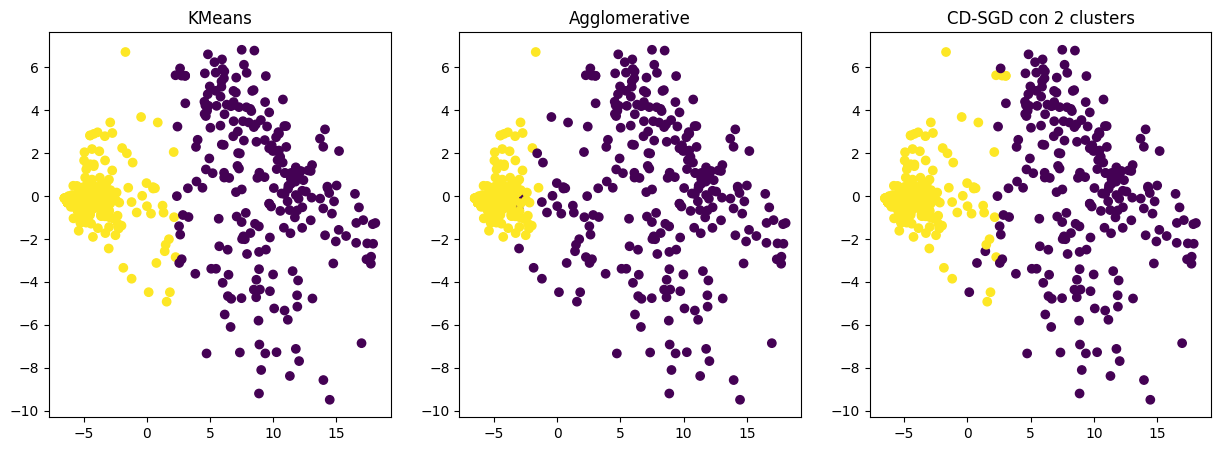

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(BreastCancer)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()